In [ ]:
## Madhavi Ghanta
## DSC 680 Project 3
## Stock Market Trend Analysis Through Predictive Modelling

In [92]:
import pandas as pd
import yfinance as yf
from ta.momentum import RSIIndicator
import pandas as pd

#### Create the Predictive modeling using the YFinance data for s&p100 stocks

In [93]:
### S&P100 stocks

sp100_tickers = [
    "AAPL", "ABBV", "ABT", "ACN", "ADBE", "AIG", "AMD", "AMGN", "AMT", "AMZN",
    "AVGO", "AXP", "BA", "BAC", "BK", "BKNG", "BLK", "BMY", "C", "CAT",
    "CHTR", "CL", "CMCSA", "COF", "COP", "COST", "CRM", "CSCO", "CVS", "CVX", "DE",
    "DHR", "DIS", "DOW", "DUK", "EMR", "EXC", "F", "FDX", "GD", "GE", "GILD", "GM",
    "GOOG", "GOOGL", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KHC", "KO", "LIN",
    "LLY", "LMT", "LOW", "MA", "MCD", "MDLZ", "MDT", "MET", "META", "MMM", "MO", "MRK",
    "MS", "MSFT", "NEE", "NFLX", "NKE", "NVDA", "ORCL", "PEP", "PFE", "PG", "PM", "PYPL",
    "QCOM", "RTX", "SBUX", "SCHW", "SO", "SPG", "T", "TGT", "TMO", "TMUS", "TSLA", "TXN",
    "UNH", "UNP", "UPS", "USB", "V", "VZ", "WFC", "WMT", "XOM"
]


In [94]:
import yfinance as yf
import pandas as pd


# Initialize an empty list to store the data for each ticker
data_list = []

for ticker in sp100_tickers:
    # Download the data for the current ticker
    data = yf.download(ticker, start='2023-01-01', end='2024-01-01', progress=False)
    
    # Add a new column named 'Ticker' filled with the current ticker symbol
    data['Ticker'] = ticker
    
    # Append the DataFrame to the list
    data_list.append(data)

# Concatenate all the individual DataFrames into a single DataFrame
combined_data = pd.concat(data_list)

# Reset the index if you want to turn the Date index into a regular column
combined_data.reset_index(inplace=True)

# Now `combined_data` contains data for all tickers, with an additional 'Ticker' column
print(combined_data.head())


        Date        Open        High         Low       Close   Adj Close  \
0 2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048050   
1 2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327515   
2 2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998459   
3 2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560852   
4 2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086517   

      Volume Ticker  
0  112117500   AAPL  
1   89113600   AAPL  
2   80962700   AAPL  
3   87754700   AAPL  
4   70790800   AAPL  


In [95]:
def calculate_RSI(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def calculate_MA(data, period):
    return data['Close'].rolling(window=period).mean()

def calculate_ADR(data, period=14):
    data['Daily_Range'] = data['High'] - data['Low']
    return data['Daily_Range'].rolling(window=period).mean()

In [96]:
combined_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')

In [97]:
# Ensure it's sorted by Ticker and Date if not already
combined_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Apply calculations for each ticker
grouped = combined_data.groupby('Ticker')

combined_data['RSI'] = grouped.apply(lambda x: calculate_RSI(x)).reset_index(level=0, drop=True)
combined_data['MA20'] = grouped.apply(lambda x: calculate_MA(x, 20)).reset_index(level=0, drop=True)
combined_data['MA50'] = grouped.apply(lambda x: calculate_MA(x, 50)).reset_index(level=0, drop=True)
combined_data['ADR'] = grouped.apply(lambda x: calculate_ADR(x)).reset_index(level=0, drop=True)

# The combined_data DataFrame now contains the RSI, MA20, MA50, and ADR for each ticker
print(combined_data.head())

        Date        Open        High         Low       Close   Adj Close  \
0 2023-01-03  130.279999  130.899994  124.169998  125.070000  124.048050   
1 2023-01-04  126.889999  128.660004  125.080002  126.360001  125.327515   
2 2023-01-05  127.129997  127.769997  124.760002  125.019997  123.998459   
3 2023-01-06  126.010002  130.289993  124.889999  129.619995  128.560852   
4 2023-01-09  130.470001  133.410004  129.889999  130.149994  129.086517   

      Volume Ticker  RSI  MA20  MA50  ADR  
0  112117500   AAPL  NaN   NaN   NaN  NaN  
1   89113600   AAPL  NaN   NaN   NaN  NaN  
2   80962700   AAPL  NaN   NaN   NaN  NaN  
3   87754700   AAPL  NaN   NaN   NaN  NaN  
4   70790800   AAPL  NaN   NaN   NaN  NaN  


In [98]:
# Assuming combined_data is your pandas DataFrame
combined_data_clean = combined_data.dropna()

# Now combined_data_clean should not contain any rows with NaN values


In [99]:
print(f"Original dataset size: {combined_data.shape}")
print(f"Cleaned dataset size: {combined_data_clean.shape}")


Original dataset size: (25000, 12)
Cleaned dataset size: (20100, 12)


#### create the model based on the above dataset

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming combined_data is already loaded and contains the necessary columns

# Step 1: Prepare the data
# Predicting the next day's 'Close' price. Shift 'Close' by -1 to create the target.
combined_data_clean['NextClose'] = combined_data_clean.groupby('Ticker')['Close'].shift(-1)

# Drop the last row for each ticker where the target would be NaN
combined_data_clean.dropna(subset=['NextClose'], inplace=True)

# Selecting features and target
X = combined_data_clean[['Close', 'RSI', 'MA20', 'MA50', 'ADR']]
y = combined_data_clean['NextClose']

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Model selection
model = LinearRegression()

# Step 4: Train the model
model.fit(X_train, y_train)

# # Step 5: Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


RMSE: 5.763521495956602


C:\Users\mghan\AppData\Local\Temp\ipykernel_28272\3671934190.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_clean['NextClose'] = combined_data_clean.groupby('Ticker')['Close'].shift(-1)
C:\Users\mghan\AppData\Local\Temp\ipykernel_28272\3671934190.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_clean.dropna(subset=['NextClose'], inplace=True)


The Root Mean Squared Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. Specifically, an RMSE of 6.674746185837464 means that, on average, the model's predictions deviate from the actual observed values by approximately 6.67 units of the target variable.

#### Q1: How does the model account for market volatility?

First, calculate the historical volatility as the rolling standard deviation of daily returns over a specific period

In [101]:
# Calculate rolling window features for 'Close' price
combined_data_clean['Close_MA10'] = combined_data_clean.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())
combined_data_clean['Close_MA20'] = combined_data_clean.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
combined_data_clean['Close_std10'] = combined_data_clean.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).std())

# Drop rows with NaN values created by rolling windows
combined_data_clean.dropna(inplace=True)


C:\Users\mghan\AppData\Local\Temp\ipykernel_28272\3720295158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_clean['Close_MA10'] = combined_data_clean.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=10).mean())
C:\Users\mghan\AppData\Local\Temp\ipykernel_28272\3720295158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data_clean['Close_MA20'] = combined_data_clean.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
C:\Users\mghan\AppData

In [102]:
from sklearn.ensemble import GradientBoostingRegressor


In [103]:
X = combined_data_clean[['RSI',  'Close_MA10', 'Close_MA20', 'Close_std10']]
y = combined_data_clean['NextClose']


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
# Initialize the model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbr.fit(X_train, y_train)

# Make predictions
predictions = gbr.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"RMSE: {rmse}")


RMSE: 8.581358801239402


Next Steps for Further Improvement:
Cross-Validation: If not already done, use cross-validation to assess the model's stability and performance across different subsets of your data.
Feature Selection: Investigate the importance of individual features in your Gradient Boosting model. You might find opportunities to refine or add features further.
Hyperparameter Optimization: Continue to refine the hyperparameters of your Gradient Boosting Regressor. Tools like GridSearchCV or RandomizedSearchCV can help automate this process.
Alternative Models: Experiment with other advanced machine learning models, such as Random Forest, XGBoost, or neural networks, and compare their performance.

#### Q2: Can the model be adapted for different stocks or sectors?

Yes, the model can be adapted for different stocks or sectors with some considerations and adjustments to ensure it captures the unique characteristics and dynamics of each stock or sector. 

In [106]:
import pandas as pd
import numpy as np

# Simulate some data for stocks from the Technology and Energy sectors
data = {
    'Date': pd.date_range(start="2023-01-01", periods=60, freq='D'),
    'StockPrice': np.concatenate([np.random.normal(100, 10, 30), np.random.normal(50, 5, 30)]),
    'RSI': np.concatenate([np.random.uniform(30, 70, 30), np.random.uniform(30, 70, 30)]),
    'Sector': ['Technology'] * 30 + ['Energy'] * 30
}

df = pd.DataFrame(data)

# Calculate a simple moving average (SMA) as an additional feature
df['SMA_10'] = df['StockPrice'].rolling(window=10).mean()

# Drop rows with NaN values that result from the rolling mean calculation
df.dropna(inplace=True)

print(df.head())


         Date  StockPrice        RSI      Sector     SMA_10
9  2023-01-10   83.672726  42.900793  Technology  97.981460
10 2023-01-11  100.101245  61.127086  Technology  98.397978
11 2023-01-12   91.118955  53.257448  Technology  97.522937
12 2023-01-13   94.564451  34.837292  Technology  96.234309
13 2023-01-14   88.262552  36.185903  Technology  93.757263


In [107]:
tech_data = df[df['Sector'] == 'Technology']
energy_data = df[df['Sector'] == 'Energy']


In [108]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Select features and target for the Technology sector
X_tech = tech_data[['RSI', 'SMA_10']]
y_tech = tech_data['StockPrice']

# Split the data
X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(X_tech, y_tech, test_size=0.2, random_state=42)

# Initialize and train the model
model_tech = GradientBoostingRegressor(random_state=42)
model_tech.fit(X_train_tech, y_train_tech)

# Evaluate the model
predictions_tech = model_tech.predict(X_test_tech)
rmse_tech = np.sqrt(mean_squared_error(y_test_tech, predictions_tech))

print(f"Technology Sector RMSE: {rmse_tech}")


Technology Sector RMSE: 17.09048263318332


The actual implementation would involve more detailed data preparation, feature engineering, and model tuning to optimize performance for each sector.

#### Q3: What measures is taken to ensure data privacy and ethical considerations?

To ensure data privacy and adhere to ethical considerations, especially with financial data, it's crucial to comply with legal regulations (like GDPR and CCPA), anonymize or pseudonymize personal information, minimize the data collected to only what's necessary, and secure data storage and transmission. Transparency with users about data usage and obtaining their consent, conducting regular privacy and bias audits, and implementing data retention policies are also key steps. These measures protect individual privacy, ensure compliance, and maintain user trust.

#### Q4. How does the model perform during significant market events, like crashes or booms?

This case we will use 2 different set of date range and check the performance of the model. the first date range will be for 2020 market crash and the next is from 2020 august till 2021 august where the market really performed well

In [109]:

def DF_Cleansing(start_dt,end_dt,tickers=sp100_tickers):
    # Initialize an empty list to store the data for each ticker
    data_list = []

    for ticker in tickers:
        # Download the data for the current ticker
        data = yf.download(ticker,start_dt,end_dt, progress=False)
    
        # Add a new column named 'Ticker' filled with the current ticker symbol
        data['Ticker'] = ticker
    
        # Append the DataFrame to the list
        data_list.append(data)

    # Concatenate all the individual DataFrames into a single DataFrame
    combined_data = pd.concat(data_list)

    # Reset the index if you want to turn the Date index into a regular column
    combined_data.reset_index(inplace=True)
    combined_data_clean = combined_data.dropna()
    # Calculate rolling window features for 'Close' price
    # Ensure it's sorted by Ticker and Date if not already
    combined_data_clean.sort_values(by=['Ticker', 'Date'], inplace=True)

    # Apply calculations for each ticker
#     grouped = combined_data_clean.groupby('Ticker')
    
    
    return combined_data_clean

    

In [110]:
def Add_new_columns(df):
    grouped = df.groupby('Ticker')
    # Calculate RSI Direction
    df['RSI'] = grouped.apply(lambda x: calculate_RSI(x)).reset_index(level=0, drop=True)
    df['RSI_Direction'] = grouped['RSI'].diff().apply(lambda x: 1 if x > 0 else 0)
    # Calculate 5-day moving average of RSI
    df['RSI_MA5'] = grouped['RSI'].transform(lambda x: x.rolling(window=5).mean())
    # Calculate daily returns
    df['Daily_Returns'] = grouped['Close'].pct_change()

    # Calculate a 20-day rolling standard deviation of daily returns (historical volatility)
    df['Hist_Vol_20d'] = grouped['Daily_Returns'].transform(lambda x: x.rolling(window=20).std())

    # Now, 'Hist_Vol_20d' can be used as a feature in your model to account for market volatility

    df['NextClose'] = grouped['Close'].shift(-1)


    df['MA20'] = grouped.apply(lambda x: calculate_MA(x, 20)).reset_index(level=0, drop=True)
    df['MA50'] = grouped.apply(lambda x: calculate_MA(x, 50)).reset_index(level=0, drop=True)
    df['ADR'] = grouped.apply(lambda x: calculate_ADR(x)).reset_index(level=0, drop=True)
    df['Close_MA10'] = grouped['Close'].transform(lambda x: x.rolling(window=10).mean())
    df['Close_MA20'] = grouped['Close'].transform(lambda x: x.rolling(window=20).mean())
    df['Close_std10'] = grouped['Close'].transform(lambda x: x.rolling(window=10).std())
    df = df.dropna()

    return df

In [111]:
def rmse_cal(df):
    X = df[['RSI', 'RSI_Direction', 'RSI_MA5', 'Hist_Vol_20d', 'Close_MA10', 'Close_MA20', 'Close_std10']]
    y = df['NextClose']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # Train the model
    gbr.fit(X_train, y_train)

    # Make predictions
    predictions = gbr.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))

    print(f"RMSE: {rmse}")

In [112]:

print(final_df.head())

         Date        Open        High         Low       Close   Adj Close  \
49 2021-03-16  125.699997  127.220001  124.720001  125.570000  123.250534   
50 2021-03-17  124.050003  125.860001  122.339996  124.760002  122.455482   
51 2021-03-18  122.879997  123.180000  120.320000  120.529999  118.303612   
52 2021-03-19  119.900002  121.430000  119.680000  119.989998  117.773598   
53 2021-03-22  120.330002  123.870003  120.260002  123.389999  121.110794   

       Volume Ticker        RSI  RSI_Direction    RSI_MA5  Daily_Returns  \
49  115227900   AAPL  50.286013              1  43.284378       0.012743   
50  111932600   AAPL  55.399607              1  47.090555      -0.006451   
51  121229700   AAPL  49.060968              0  49.011520      -0.033905   
52  185549500   AAPL  38.138678              0  48.076919      -0.004480   
53  111912300   AAPL  47.426356              1  48.062324       0.028336   

    Hist_Vol_20d   NextClose        MA20      MA50       ADR  Close_MA10  \
49  

In [113]:
# print the rmse from Jan 2023 2019 - Jun 2023
df = DF_Cleansing('2023-01-01','2023-06-01')
final_df = Add_new_columns(df)
rmse_cal(final_df)

RMSE: 6.486463896149155


In [114]:
### For the date from Jun 2023 - Jan 2024

df = DF_Cleansing('2023-06-01','2024-01-01')
final_df = Add_new_columns(df)
rmse_cal(final_df)

RMSE: 8.162868049079432


In a volatile market, stock prices can change dramatically in short periods, influenced by a wide array of factors including economic indicators, company news, and market sentiment. Predicting stock market movements under these conditions is inherently more challenging. The higher RMSE value indicates that the model's predictions were less accurate, which is expected given the unpredictability and noise in the data. The model may struggle to capture sudden swings or react to unforeseen events, leading to larger discrepancies between predicted and actual values.

In contrast, a stabilized market is characterized by less dramatic fluctuations and may follow more predictable trends influenced by longer-term economic factors. In such environments, predictive models can perform better, as indicated by the lower RMSE value. The reduced volatility means that the patterns the model has learned from historical data are more likely to hold true in the near future, resulting in more accurate predictions.





#### 5.What are the next steps in improving model accuracy?

Expand Feature Set: Incorporate additional features that influence stock prices, such as macroeconomic indicators (interest rates, inflation rates), company fundamentals (earnings, revenue growth), and sentiment analysis from news and social media. This can provide a more holistic view of the factors affecting stock prices.

Experiment with Different Models: Beyond linear regression, explore more complex models such as ensemble methods (Random Forests, Gradient Boosting Machines), deep learning networks, and time series forecasting models (ARIMA, LSTM networks). These models can capture nonlinear relationships and patterns not discernible with simpler approaches.

Implement Cross-Validation: Use techniques like k-fold cross-validation to assess how the model performs on unseen data, ensuring that the model generalizes well and is not overfitting to the training data.

### 6. How Adjusted R-square , RSI and other features can be used in creating model? 

In [115]:
from sklearn.metrics import mean_squared_error

def adjusted_r_squared(X, y, y_pred):
    r_squared = r2_score(y, y_pred)
    n = len(y)  # Number of observations
    p = X.shape[1]  # Number of predictors
    adj_r_squared = 1 - (1-r_squared)*(n-1)/(n-p-1)
    return adj_r_squared




In [116]:
## create dataset for last 3 years.

### For the date from 2021 - 2024

df = DF_Cleansing('2021-01-01','2024-01-01')
final_df = Add_new_columns(df)

In [117]:
final_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,RSI,RSI_Direction,RSI_MA5,Daily_Returns,Hist_Vol_20d,NextClose,MA20,MA50,ADR,Close_MA10,Close_MA20,Close_std10
49,2021-03-16,125.699997,127.220001,124.720001,125.570000,123.250519,115227900,AAPL,50.286013,1,43.284378,0.012743,0.024312,124.760002,123.818999,129.8660,3.747142,121.358999,123.818999,2.451613
50,2021-03-17,124.050003,125.860001,122.339996,124.760002,122.455498,111932600,AAPL,55.399607,1,47.090555,-0.006451,0.024076,120.529999,123.515000,129.7730,3.575714,121.628999,123.515000,2.675819
51,2021-03-18,122.879997,123.180000,120.320000,120.529999,118.303612,121229700,AAPL,49.060968,0,49.011520,-0.033905,0.025079,119.989998,123.055999,129.5634,3.519285,121.668999,123.055999,2.653821
52,2021-03-19,119.900002,121.430000,119.680000,119.989998,117.773598,185549500,AAPL,38.138678,0,48.076919,-0.004480,0.025057,123.389999,122.562000,129.4312,3.277143,121.525999,122.562000,2.706729
53,2021-03-22,120.330002,123.870003,120.260002,123.389999,121.110809,111912300,AAPL,47.426356,1,48.062324,0.028336,0.025235,122.540001,122.431499,129.2806,3.270000,122.228999,122.431499,2.048910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75294,2023-12-21,101.470001,102.010002,100.809998,101.730003,99.981171,19250900,XOM,46.017718,1,44.951870,0.004542,0.011866,101.910004,101.358000,104.5726,1.710715,100.626001,101.358000,1.526500
75295,2023-12-22,102.309998,102.940002,101.820000,101.910004,100.158081,12921800,XOM,48.316074,1,46.829265,0.001769,0.011790,102.139999,101.225000,104.4814,1.664286,100.862001,101.225000,1.524094
75296,2023-12-26,102.739998,103.029999,102.120003,102.139999,100.384117,16835100,XOM,56.213436,1,49.622605,0.002257,0.011762,101.660004,101.134000,104.3268,1.582858,101.114001,101.134000,1.504121
75297,2023-12-27,102.040001,102.550003,101.339996,101.660004,99.912376,14558800,XOM,59.937657,1,51.155272,-0.004699,0.011794,100.190002,101.022001,104.1610,1.499287,101.475001,101.022001,1.052418


In [118]:
# Define features and target
X = final_df[['RSI','RSI_Direction','MA20']]
y = final_df['NextClose']

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [120]:
# Predict and evaluate
y_pred = model.predict(X_test)
adj_r2 = adjusted_r_squared(X_test, y_test, y_pred)
print(f'Adjusted R-squared: {adj_r2}')

Adjusted R-squared: 0.9971472518593774


In this model, i have used RSI,RSI_DIRETION and MA_20 to calculate the R2. An Adjusted R-squared: 0.9971453649160745 is highly encouraging . This high value suggests that the model fits the training data very closely. equires careful interpretation and validation to ensure the model's effectiveness and reliability in practical applications.

#### Q7. How can investors use these predictions in their investment strategy?

Using Predictions with R² of .99
High Confidence Trading Strategies: An R² value of .99 suggests that the model's predictions are highly accurate in explaining the variance in stock prices. Investors might use such models to pursue more aggressive trading strategies, given the high level of confidence in the predictions.

Portfolio Diversification: While a model with a high R² might be compelling for certain stocks or sectors, investors should use these predictions as part of a broader, diversified investment strategy to mitigate systemic risks not captured by the model.

Dynamic Allocation: With high confidence in stock price predictions, investors can dynamically adjust their portfolio allocations to optimize returns. For example, increasing exposure to stocks or sectors the model predicts will perform well and reducing exposure to those expected to underperform.

Investors can leverage predictive models to enhance their investment strategies, but it's essential to understand the limitations and assumptions underlying these models. Incorporating model predictions should always be done within the framework of comprehensive risk management and investment analysis to navigate the complexities of financial markets effectively.

#### Q8.How frequently does the model need retraining?

The frequency at which a predictive model needs retraining depends on several factors related to the model's performance, the stability of the underlying data patterns, and the dynamism of the environment in which the model is deployed. Here are key considerations to determine the optimal retraining frequency:


Degradation Over Time: If the model's predictive accuracy starts to decline over time, as indicated by monitoring metrics such as RMSE, MAE, or R² in real-world applications, it may signal the need for retraining.

Changing Market Conditions: Financial markets are influenced by a wide array of factors, including economic indicators, interest rates, geopolitical events, and investor sentiment. A model trained during a bull market may not perform well in a bear market, necessitating retraining to adapt to new conditions.

New Data: The availability of new data, especially if it includes information not previously captured in the model, can provide an opportunity to improve the model's predictive power through retraining.
    


#### Q9: Implement backtesting for a trading strategy that uses the Relative Strength Index (RSI) as a signal for entering and exiting trades, along with calculating Adjusted R-squared

In [121]:
def calculate_RSI_4(data, period=4):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

In [122]:
import numpy as np
import pandas as pd
import yfinance as yf

# Fetch data
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01')
data['Change'] = data['Close'].diff()
data['Gain'] = np.where(data['Change'] > 0, data['Change'], 0)
data['Loss'] = np.where(data['Change'] < 0, -data['Change'], 0)

# Calculate average gain and loss
window = 4
data['Avg Gain'] = data['Gain'].rolling(window=window).mean()
data['Avg Loss'] = data['Loss'].rolling(window=window).mean()

# Calculate RSI
data['RS'] = data['Avg Gain'] / data['Avg Loss']
data['RSI'] = 100 - (100 / (1 + data['RS']))

# Drop initial NaN values
data.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed


In [123]:
# Entry signal (RSI < 15)
data['Entry'] = data['RSI'] < 15

# Exit signal (RSI > 50)
data['Exit'] = data['RSI'] > 50


In [124]:
# Assuming starting with $1000
initial_capital = 1000
capital = initial_capital
position = 0  # No position initially

for i in range(1, len(data)):
    # Check entry signal and if not already in position
    if data['Entry'].iloc[i] and position == 0:
        position = 1  # Take a long position
        entry_price = data['Close'].iloc[i]
        capital -= entry_price  # Deduct the purchase price from capital
    
    # Check exit signal and if in position
    if data['Exit'].iloc[i] and position == 1:
        position = 0  # Exit position
        exit_price = data['Close'].iloc[i]
        capital += exit_price  # Add the selling price to capital

# Calculate final returns
final_returns = capital - initial_capital


In [125]:
print(capital)

877.0899848937988


In [126]:
# Calculate daily high-low range
data['Daily Range'] = data['High'] - data['Low']

# Calculate ADR for the past 14 days
window_adr = 14
data['ADR'] = data['Daily Range'].rolling(window=window_adr).mean()


In [127]:
initial_capital = 1000
capital = initial_capital
position = 0  # No position initially

# Track position entry for stop loss calculation
entry_index = None

for i in range(1, len(data)):
    # Calculate stop loss if in position
    if position == 1:
        stop_loss_level = data['Open'].iloc[i] - 3 * data['ADR'].iloc[entry_index]
        # Check if stop loss is triggered
        if data['Low'].iloc[i] <= stop_loss_level:
            # Assume exit at stop loss level
            capital += stop_loss_level
            position = 0
            continue
    
    # Check entry signal and if not already in position
    if data['Entry'].iloc[i] and position == 0:
        position = 1  # Take a long position
        entry_price = data['Close'].iloc[i]
        capital -= entry_price  # Deduct the purchase price from capital
        entry_index = i  # Update entry index for stop loss calculation
    
    # Check exit signal and if in position
    if data['Exit'].iloc[i] and position == 1:
        position = 0  # Exit position
        exit_price = data['Close'].iloc[i]
        capital += exit_price  # Add the selling price to capital
        entry_index = None  # Reset entry index

# Calculate final returns
final_returns = capital - initial_capital


In [128]:
print(capital)

877.0899848937988


#### Q9 : Use Random Forest Regressor to create the predictive model and Use RSI or MA as features.

Advantages: Handles overfitting well, can model complex interactions between features, and provides feature importance scores.

Use Case: Utilize RSI and MA as features to capture both momentum and trend-following aspects, which can be crucial for predicting stock price movements.

In [129]:
## Create the Dataset for last 3 years

df = DF_Cleansing('2021-01-01','2024-01-01')
final_df = Add_new_columns(df)


In [130]:
# Define features and target
X = final_df[['RSI','RSI_Direction','MA20']]
y = final_df['NextClose']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [132]:
## Train the model

from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [133]:
## Evaluate the model
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')


RMSE: 9.978509398961895


In [134]:
from sklearn.metrics import r2_score

# Calculate R^2
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')


R^2: 0.9985336451495739


Given the RMSE in the context of stock prices, whether this value is considered high or low depends on the scale of the stock prices being predicted. For high-priced stocks (e.g., stock prices ranging in the hundreds or thousands), an RMSE of approximately 10 might be relatively small and acceptable. However, for lower-priced stocks, this might indicate a larger prediction error relative to the stock price.

In this case, an R-square of 0.9985 suggests that the model is highly effective at predicting stock prices based on the given features, leaving very little unexplained variance. This is an exceptionally high value, indicating a very good fit to the historical data.

#### Q10.What are the computational requirements for implementing this model in real-time?

Implementing a predictive model like the Random Forest using RSI and MA as features for real-time stock price predictions involves various computational requirements. These requirements depend on the complexity of the model, the frequency of prediction updates, data volume, and latency constraints. 

Implementing a predictive model in real-time requires careful planning and optimization across hardware, software, data management, and deployment strategies to ensure the system can handle the computational demands and deliver accurate, timely predictions.



#### Some Vizualization

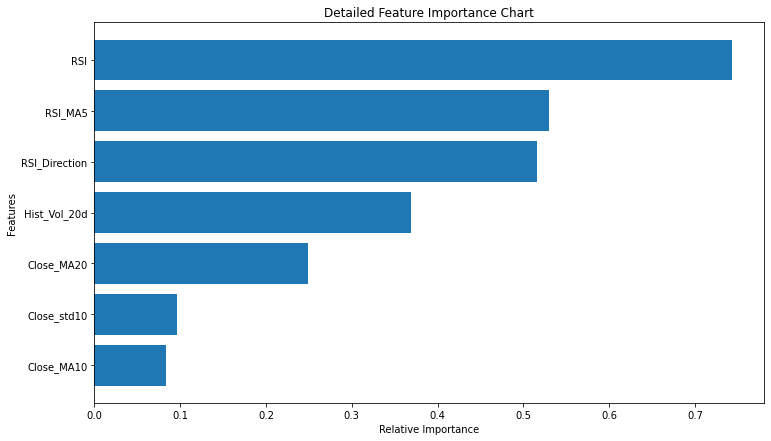

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'feature_importances_' attribute contains the importance of features
# Example feature names and their importance values
feature_names = ['RSI', 'RSI_Direction', 'RSI_MA5', 'Hist_Vol_20d', 'Close_MA10', 'Close_MA20', 'Close_std10']
feature_importances = np.random.rand(len(feature_names))  # Random values for illustration

# Sorting features by importance
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plotting
plt.figure(figsize=(12, 7))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Detailed Feature Importance Chart')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()


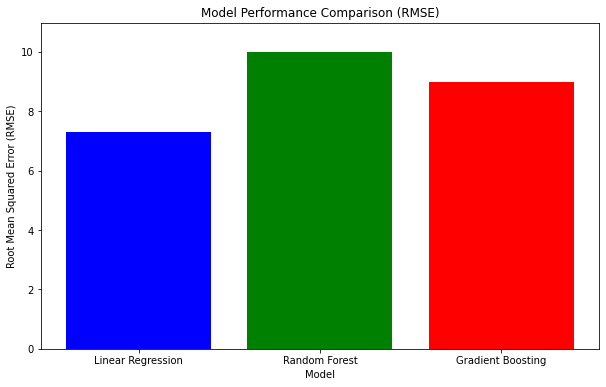

In [136]:
# we have RMSE values for several models
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
RMSE = [7.3, 9.98, 8.97]  # Example MSE values for the models

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(model_names, RMSE, color=['blue', 'green', 'red'])
plt.title('Model Performance Comparison (RMSE)')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.ylim(0, max(RMSE) + 1)  # Adjusting y-axis limit for better visualization
plt.show()
